### Imports and Utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

/home/adeshwall_dg/anaconda3/envs/mbo/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.models.fully_bayesian import MIN_INFERRED_NOISE_LEVEL
from botorch.models.transforms import Normalize, Standardize
from gpytorch.constraints import GreaterThan
from gpytorch.kernels import ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import GammaPrior

In [ ]:
from gauche.dataloader import DataLoaderMP
from gauche.dataloader.data_utils import transform_data
from gauche.kernels.string_kernels.sskkernel import pad, encode_string, build_one_hot, SubsequenceStringKernel

In [5]:
# plotting util
def cv_plot(median, q1, q2, y_test):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot([torch.min(median), torch.max(median)], [torch.min(median), torch.max(median)], "b--", lw=2)
    yerr1, yerr2 = median - q1, q2 - median
    yerr = torch.cat((yerr1.unsqueeze(0), yerr2.unsqueeze(0)), dim=0).squeeze(-1)
    markers, caps, bars = ax.errorbar(
        y_test.squeeze(-1).cpu(),
        median.squeeze(-1).cpu(),
        yerr=yerr.cpu(),
        fmt=".",
        capsize=4,
        elinewidth=2.0,
        ms=14,
        c="k",
        ecolor="gray",
    )
    [bar.set_alpha(0.8) for bar in bars]
    [cap.set_alpha(0.8) for cap in caps]
    ax.set_xlabel("True value", fontsize=20)
    ax.set_ylabel("Predicted value", fontsize=20)
    ax.set_aspect("equal")
    ax.grid(True)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tkwargs = {"dtype": torch.float, "device": device}
print(tkwargs)

{'dtype': torch.float32, 'device': device(type='cuda')}


### Data setup

In [7]:
# Regression experiments parameters, number of random splits and split size
n_trials = 20
test_set_size = 0.2

In [8]:
loader = DataLoaderMP()
loader.load_benchmark("Photoswitch", "data/property_prediction/photoswitches.csv")
smiles = loader.features
targets = loader.labels
print(f'len(smiles) {len(smiles)} | len(targets) {len(targets)}')

len(smiles) 392 | len(targets) 392


In [9]:
maxlen = np.max([len(x) for x in smiles])
# get alphabet of characters used in candidate set (to init SSK)
alphabet = list({l for word in smiles for l in word})
print(f'alphabet \n {alphabet} \n length of alphabet {len(alphabet)}')
print(f'maxlen {maxlen}')

alphabet 
 ['F', 'S', '5', '7', '%', '@', '2', 'B', 'N', 'I', '[', '8', 'c', 'l', '=', '\\', '/', '1', '(', '9', '0', 'O', '-', '4', 'r', '#', 'n', 's', ')', 'H', ']', '3', '6', 'C', '+'] 
 length of alphabet 35
maxlen 122


### Model Fits and Prediction

In [10]:
def get_gp_model(X, Y):
    likelihood = GaussianLikelihood(
        noise_prior=GammaPrior(torch.tensor(0.9, **tkwargs), torch.tensor(10.0, **tkwargs)),
        noise_constraint=GreaterThan(MIN_INFERRED_NOISE_LEVEL),
    )
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        SubsequenceStringKernel(embds, index, alphabet, maxlen, **tkwargs),
    )
    gp_model = SingleTaskGP(
        train_X=X,
        train_Y=Y,
        outcome_transform=Standardize(1),
        likelihood=likelihood,
        covar_module=covar_module,
    )
    mll = ExactMarginalLogLikelihood(model=gp_model, likelihood=gp_model.likelihood)
    # ideally we can optimize over the kernel hyper-parameters of the string kernel
    # however, the gpu memory usage in batch (GPU) version of the kernel is quite high
    # while the standard non-batch version is relatively slow for kernel evaluation.
    # Nevertheless, the kernel is very robust to choices of different these hyper-params.
    mll.model.covar_module.base_kernel.raw_order_coefs.requires_grad = False
    mll.model.covar_module.base_kernel.raw_match_decay.requires_grad = False
    mll.model.covar_module.base_kernel.raw_gap_decay.requires_grad = False
    return mll, gp_model

In [11]:
embds, index = build_one_hot(alphabet)
embds = embds.to(**tkwargs)
all_encoded_smiles = torch.cat([pad(encode_string(x, index), maxlen).unsqueeze(0) for x in smiles], dim=0)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(all_encoded_smiles, targets, test_size=test_set_size, random_state=0)
X_train = X_train.to(**tkwargs)
X_test = X_test.to(**tkwargs)
y_train = torch.tensor(y_train, **tkwargs)
y_test = torch.tensor(y_test, **tkwargs)

In [ ]:
mll, gp_model = get_gp_model(X_train, y_train)
fit_gpytorch_model(mll)

/home/adeshwall_dg/anaconda3/envs/mbo/lib/python3.7/site-packages/gpytorch/lazy/lazy_tensor.py:1811: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484772347/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


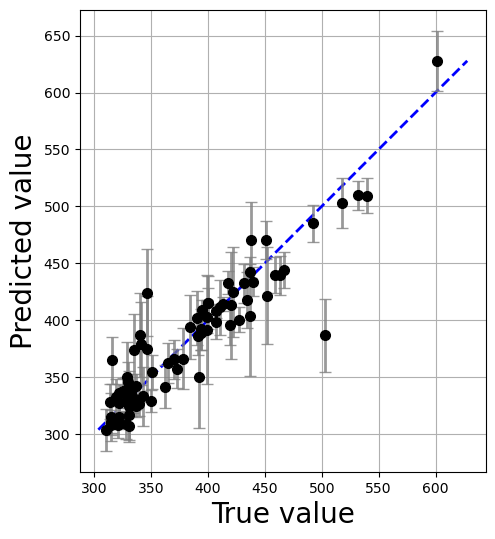

In [14]:
posterior = gp_model.posterior(X_test)
median = posterior.mean.cpu().detach()
std = posterior.variance.cpu().detach()**(1/2)
q1 = median - std
q2 = median + std
cv_plot(median, q1, q2, y_test)

In [15]:
print(r2_score(median.squeeze(1), y_test.cpu().detach().squeeze(1)))
print(mean_absolute_error(median.squeeze(1), y_test.cpu().detach().squeeze(1)))

0.8345390628906045
16.316833


### Testing BoTorch compatibility

In [16]:
from botorch.acquisition import qExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler

In [17]:
qmc_sampler = SobolQMCNormalSampler(num_samples=32)
qEI = qExpectedImprovement(
    model=gp_model, best_f=y_train.max(),
    sampler=qmc_sampler)
print(qEI(X_test.unsqueeze(1)))

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 13.2220,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       device='cuda:0', grad_fn=<MeanBackward1>)
